In [87]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(rc={'lines.markeredgewidth': 1.0})
%matplotlib inline

### Data loading

In [2]:
# load all electrical load, years 2011 - 2016, into one data frame
df_load = pd.DataFrame()
for fname in glob.glob("pjm_load/*.txt"):
    with open(fname, "r") as f:
        header = f.readline().strip()
    year = fname.split("/")[1].split(".")[0]
    df_load = df_load.append(pd.read_csv(fname, names = header.split(",") + ["DST"], skiprows=1, 
                                         parse_dates=["DAY"], dayfirst=False))

In [22]:
# load weather
df_weather = pd.read_csv("weather_kpit.csv", parse_dates=["Local Time"], 
                         dayfirst=False, low_memory=False)
df_weather["Date"] = df_weather["Local Time"].apply(lambda x : x.date())

In [363]:
# get max temperature and max load for each date
df_daily = df_weather.loc[:,["Date", "Temperature"]].groupby("Date").max()
df_daily["Load"] = df_load.loc[:,["DAY", "DUQ"]].groupby("DAY").max()/1000.0
df_summer = df_daily.loc[map(lambda x : x.month >= 6 and x.month <= 8, df_daily.index),:]

### Plot data

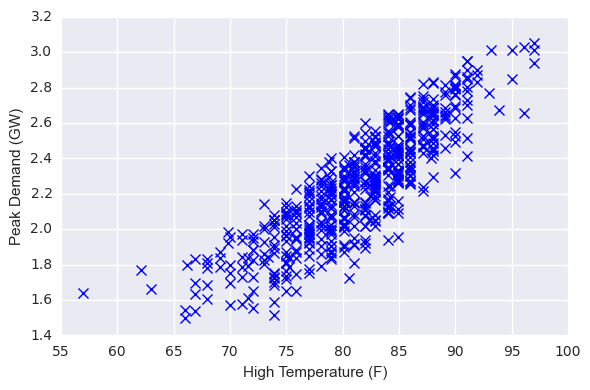

In [328]:
plt.plot(df_summer["Temperature"], df_summer["Load"], "bx")
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.xlabel("High Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.tight_layout()
plt.savefig("scatter.pdf")

### Least squares fit

In [373]:
x = df_summer.loc[:,"Temperature"]
y = df_summer.loc[:,"Load"]
theta1 = np.sum(x*(y-np.mean(y)))/np.sum(x*(x-np.mean(x)))
theta2 = -theta1*np.mean(x) + np.mean(y)
print theta1, theta2

0.0459741456924 -1.48904145647


In [411]:
X = np.vstack([df_summer.loc[:,"Temperature"], np.ones(len(df_summer))]).T
y = df_summer.loc[:,"Load"]
theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))
print theta

[ 0.04597415 -1.48904146]


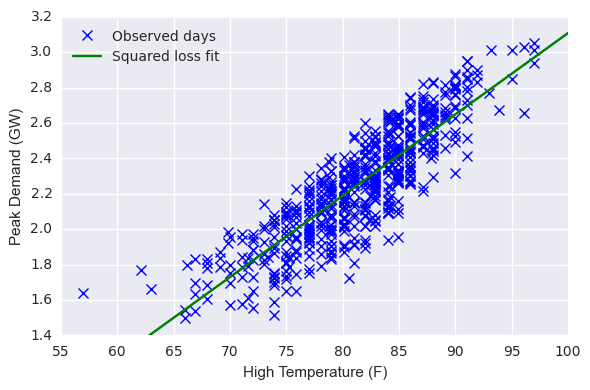

In [338]:
plt.plot(df_summer["Temperature"], df_summer["Load"], "bx",
         xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'g-')
plt.ylim(ylim)
plt.legend(["Observed days", "Squared loss fit", "Absolute loss fit"], loc="upper left")
plt.xlabel("High Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.tight_layout()
plt.savefig("fit.pdf")

### Additional features

In [429]:
df_summer.loc[:,"Weekday"] = map(lambda x : x.weekday() <= 4, df_summer.index)
X = np.vstack([df_summer.loc[:,"Temperature"], 
               df_summer.loc[:,"Weekday"],
               np.ones(len(df_summer))]).T
y = df_summer.loc[:,"Load"]
theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))
print theta

[ 0.04636701  0.22759987 -1.68346361]


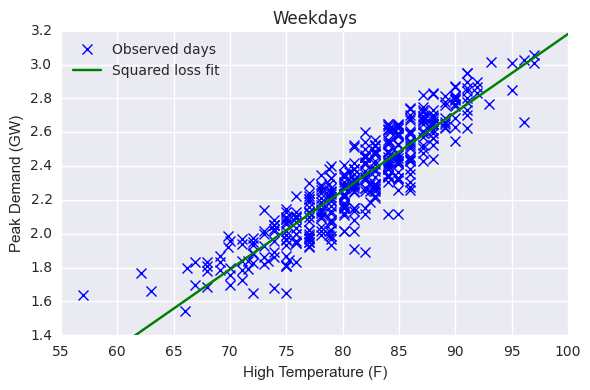

In [421]:
plt.plot(df_summer[df_summer["Weekday"]==1]["Temperature"], 
         df_summer[df_summer["Weekday"]==1]["Load"], "bx",
         xlim, [theta[0]*xlim[0]+theta[1]+theta[2], theta[0]*xlim[1]+theta[1]+theta[2]], 'g-')
plt.ylim(ylim)
plt.legend(["Observed days", "Squared loss fit", "Absolute loss fit"], loc="upper left")
plt.xlabel("High Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.title("Weekdays")
plt.tight_layout()
plt.savefig("weekday_fit.pdf")

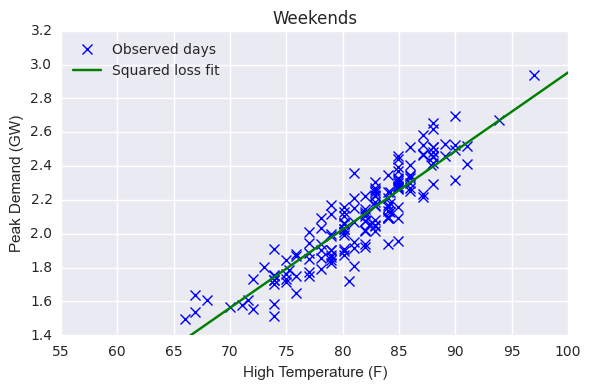

In [422]:
plt.plot(df_summer[df_summer["Weekday"]==0]["Temperature"], 
         df_summer[df_summer["Weekday"]==0]["Load"], "bx",
         xlim, [theta[0]*xlim[0]+theta[2], theta[0]*xlim[1]+theta[2]], 'g-')
plt.ylim(ylim)
plt.legend(["Observed days", "Squared loss fit", "Absolute loss fit"], loc="upper left")
plt.xlabel("High Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.title("Weekends")
plt.tight_layout()
plt.savefig("weekends_fit.pdf")

### Gradient descent

In [430]:
def gradient_descent_squared_loss(X, y, T, alpha):
    m,n = X.shape
    theta = np.zeros(n)
    f = np.zeros(T)
    for i in range(T):
        f[i] = 0.5*np.linalg.norm(X.dot(theta) - y)**2
        g = X.T.dot(X.dot(theta) - y)
        theta = theta - alpha*g
    return theta, f
       
# compute scaled version
X0 = X[:,:2]
X0 = np.hstack([(X0 - np.mean(X0,axis=0))/np.std(X0,axis=0), np.ones((X.shape[0],1))])
th, f0 = gradient_descent_squared_loss(X0,y,20,1e-3)

# to compare coefficient to solution above, transform back to original space
th[:2] = th[:2]/np.std(X[:,:2], axis=0)
th[-1] -= th[:2].dot(np.mean(X[:,:2],axis=0))

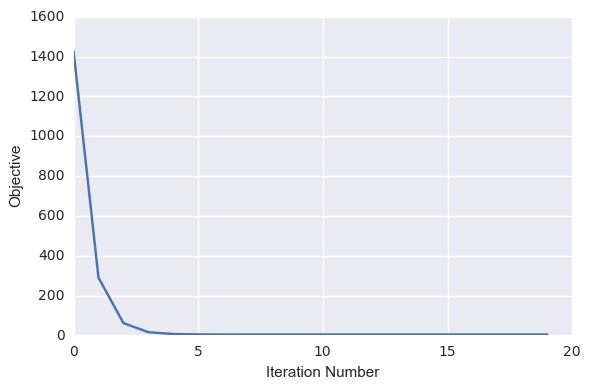

In [408]:
plt.plot(f0)
plt.xlabel("Iteration Number")
plt.ylabel("Objective")
plt.tight_layout()
plt.savefig("gradient_descent_squared_err.pdf")

### Absolute loss

In [412]:
def gradient_descent_absolute_loss(X, y, T, alpha):
    m,n = X.shape
    theta = np.zeros(n)
    f = np.zeros(T)
    for i in range(T):
        f[i] = np.linalg.norm(X.dot(theta) - y,1)
        g = X.T.dot(np.sign(X.dot(theta) - y))
        theta = theta - alpha*g
    return theta, f
       
# compute scaled version
X0 = np.copy(X)
X0[:,0] = (X0[:,0] - np.mean(X[:,0])) / np.std(X[:,0])
th, f0 = gradient_descent_absolute_loss(X0,y,200,1e-4)

# transform back to original space
th[0] /= np.std(X[:,0])
th[1] -= th[0]*np.mean(X[:,0])


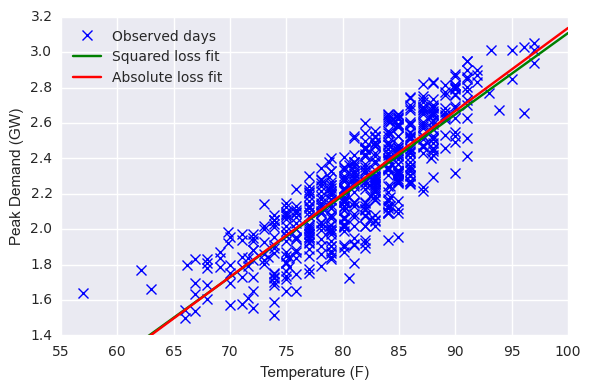

In [415]:
# run after the original least squares with only two features
plt.plot(df_summer["Temperature"], df_summer["Load"], "bx",
         xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'g-',
         xlim, [th[0]*xlim[0]+th[1], th[0]*xlim[1]+th[1]], 'r-')
plt.ylim(ylim)
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")
plt.legend(["Observed days", "Squared loss fit", "Absolute loss fit"], loc="upper left")
plt.tight_layout()
plt.savefig("abs_fit.pdf")